<a href="https://colab.research.google.com/github/satishgc227/seismic-canvas/blob/master/fault_line_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! git clone https://github.com/xinwucwp/faultSeg.git


Cloning into 'faultSeg'...
remote: Enumerating objects: 814, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 814 (delta 78), reused 79 (delta 37), pack-reused 676
Receiving objects: 100% (814/814), 1.83 GiB | 33.92 MiB/s, done.
Resolving deltas: 100% (374/374), done.
Checking out files: 100% (100/100), done.


In [3]:



import math
import skimage
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
#from keras import backend
from keras.layers import *
from keras.models import load_model
#from skimage.measure import compare_psnr
from unet3 import cross_entropy_balanced
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""

pngDir = './png/'
md = 60#,65,70 #trained models at different epoch
model = load_model('model/fseg-'+str(md)+'.hdf5',
        custom_objects={'cross_entropy_balanced': cross_entropy_balanced})


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement skimage (from versions: 0.0)
ERROR: No matching distribution found for skimage


ModuleNotFoundError: ignored

In [4]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:

import math
import skimage
import numpy as np
import os
import matplotlib.pyplot as plt


In [7]:

import tensorflow as tf
from keras import backend
from keras.layers import *
from keras.models import load_model

In [9]:
def cross_entropy_balanced(y_true, y_pred):
    # Note: tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits, 
    # Keras expects probabilities.
    # transform y_pred back to logits
    _epsilon = _to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred   = tf.clip_by_va

lue(y_pred, _epsilon, 1 - _epsilon)
    y_pred   = tf.log(y_pred/ (1 - y_pred))

    y_true = tf.cast(y_true, tf.float32)

    count_neg = tf.reduce_sum(1. - y_true)
    count_pos = tf.reduce_sum(y_true)

    beta = count_neg / (count_neg + count_pos)

    pos_weight = beta / (1 - beta)

    cost = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=pos_weight)

    cost = tf.reduce_mean(cost * (1 - beta))

    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)


In [11]:
from skimage.metrics import peak_signal_noise_ratio

In [12]:
import os

In [13]:
pngDir = './png/'

In [20]:
md = 65 #,65,70 #trained models at different epoch

In [23]:
model = load_model('/content/faultSeg/model/fseg-'+str(md)+'.hdf5',custom_objects={'cross_entropy_balanced': cross_entropy_balanced})

In [22]:
pwd


'/content/faultSeg'

1/1 [==============================] - 14s 14s/step


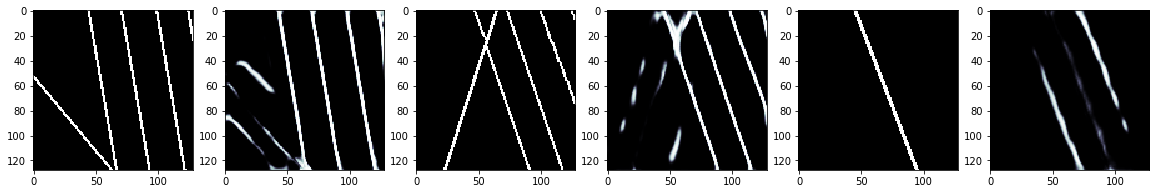

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
seismPath = "/content/faultSeg/data/validation/fault/"
faultPath = "/content/faultSeg/data/validation/fault/"
n1,n2,n3=128,128,128
dk = 2
gx = np.fromfile(seismPath+str(dk)+'.dat',dtype=np.single)
fx = np.fromfile(faultPath+str(dk)+'.dat',dtype=np.single)
gx = np.reshape(gx,(n1,n2,n3))
fx = np.reshape(fx,(n1,n2,n3))
gm = np.mean(gx)
gs = np.std(gx)
gx = gx-gm
gx = gx/gs
gx = np.transpose(gx)
fx = np.transpose(fx)
fp = model.predict(np.reshape(gx,(1,n1,n2,n3,1)),verbose=1)
fp = fp[0,:,:,:,0]
fig = plt.figure(figsize=(20,20))
#time slice
k1 = 50
plt.subplot(1, 6, 1)
imgplot1 = plt.imshow(gx[k1,:,:],cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 2)
imgplot2 = plt.imshow(fp[k1,:,:],cmap=plt.cm.bone,interpolation='nearest',aspect=1)
#inline slice
k2 = 110
plt.subplot(1, 6, 3)
imgplot1 = plt.imshow(gx[:,k2,:],cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 4)
imgplot2 = plt.imshow(fp[:,k2,:],cmap=plt.cm.bone,interpolation='nearest',aspect=1)

#xline slice
k3 = 10
plt.subplot(1, 6, 5)
imgplot1 = plt.imshow(gx[:,:,k3],cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 6)
imgplot2 = plt.imshow(fp[:,:,k3],cmap=plt.cm.bone,interpolation='nearest',aspect=1)


In [31]:

import matplotlib.pyplot as plt
%matplotlib inline
#seismPath = "./data/prediction/f3d/"
n3,n2,n1=512,384,128
gx = np.fromfile("/content/drive/MyDrive/Important datasets for seismic data/gxl.dat",dtype=np.single)
gx = np.reshape(gx,(n3,n2,n1))
gm = np.mean(gx)
gs = np.std(gx)
gx = gx-gm
gx = gx/gs
gx = np.transpose(gx)
fp = model.predict(np.reshape(gx,(1,n1,n2,n3,1)),verbose=1)
fp = fp[0,:,:,:,0]
ft = np.transpose(fp)
ft.tofile("/content/faultSeg/data/prediction/f3d"+"fp.dat",format="%4")


1/1 [==============================] - 148s 148s/step


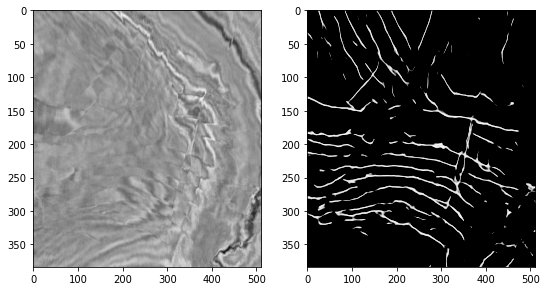

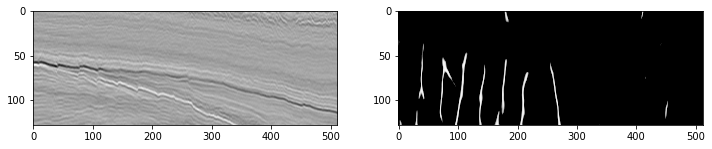

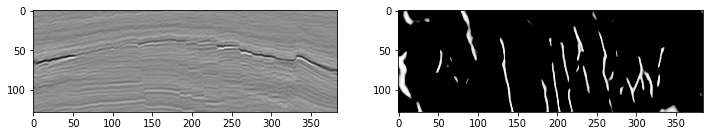

In [32]:

from matplotlib.colors import Normalize
from PIL import Image

k1,k2,k3 = 99,29,29
gx1 = gx[k1,:,:]
gy1 = fp[k1,:,:]
gx2 = gx[:,k2,:]
gy2 = fp[:,k2,:]
gx3 = gx[:,:,k3]
gy3 = fp[:,:,k3]

#xline slice
fig = plt.figure(figsize=(9,9))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx1,aspect=1.5,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy1,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)

#inline slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx2,aspect=1.5,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy2,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)

#time slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx3,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy3,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
